In [1]:
import numpy as np
import sys

from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score

from src.loader import CumuloDataset
from src.utils import make_directory

In [2]:
data_dir = '../DATA/npz/label/'
dataset = CumuloDataset(root_dir=data_dir, ext="npz")

In [3]:
xs = []
ys = []

for d in dataset:
    xs.append(d[1]) # radiances
    ys.append(d[4]) # labels

shape = xs[0].shape
xs = np.vstack(xs).reshape(-1, shape[1] * shape[2] * shape[3]) # flatten tiles
ys = np.hstack(ys)

print(xs.shape, ys.shape)

(1094, 117) (1094,)


In [4]:
print(min(ys), max(ys))

0.0 7.0


In [5]:
from sklearn.model_selection import train_test_split

train_xs, test_xs, train_ys, test_ys = train_test_split(xs, ys, test_size=0.20, random_state=42)

train_xs, val_xs, train_ys, val_ys = train_test_split(train_xs, train_ys, test_size=0.125, random_state=42)

print(train_xs.shape, train_ys.shape, val_xs.shape, val_ys.shape, test_xs.shape, test_ys.shape)

(765, 117) (765,) (110, 117) (110,) (219, 117) (219,)


In [6]:
import lightgbm as lgb

lgb_train = lgb.Dataset(train_xs, train_ys)
lgb_valid = lgb.Dataset(val_xs, val_ys)

In [7]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'verbose': 0,
    'num_classes': 8,
    "num_iterations": 100,
}

In [8]:
gbm = lgb.train(params, lgb_train, valid_sets=[lgb_valid])

/usr/local/lib/python3.5/dist-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's multi_logloss: 1.43781
[2]	valid_0's multi_logloss: 1.34706
[3]	valid_0's multi_logloss: 1.26364
[4]	valid_0's multi_logloss: 1.20397
[5]	valid_0's multi_logloss: 1.14726
[6]	valid_0's multi_logloss: 1.10386
[7]	valid_0's multi_logloss: 1.0622
[8]	valid_0's multi_logloss: 1.02746
[9]	valid_0's multi_logloss: 0.998561
[10]	valid_0's multi_logloss: 0.970639
[11]	valid_0's multi_logloss: 0.946899
[12]	valid_0's multi_logloss: 0.933115
[13]	valid_0's multi_logloss: 0.918787
[14]	valid_0's multi_logloss: 0.900433
[15]	valid_0's multi_logloss: 0.88656
[16]	valid_0's multi_logloss: 0.866991
[17]	valid_0's multi_logloss: 0.856402
[18]	valid_0's multi_logloss: 0.845481
[19]	valid_0's multi_logloss: 0.834886
[20]	valid_0's multi_logloss: 0.82451
[21]	valid_0's multi_logloss: 0.811106
[22]	valid_0's multi_logloss: 0.800759
[23]	valid_0's multi_logloss: 0.791699
[24]	valid_0's multi_logloss: 0.785686
[25]	valid_0's multi_logloss: 0.779878
[26]	valid_0's multi_logloss: 0.770358
[27]	v

In [9]:
train_prob_pred = gbm.predict(train_xs, num_iteration = gbm.best_iteration)
val_prob_pred = gbm.predict(val_xs, num_iteration = gbm.best_iteration)
test_prob_pred = gbm.predict(test_xs, num_iteration = gbm.best_iteration)

In [10]:
# take argmax of prediction probabilities
train_y_pred = np.argmax(train_prob_pred, 1)
val_y_pred = np.argmax(val_prob_pred, 1)
test_y_pred = np.argmax(test_prob_pred, 1)

In [11]:
accuracy = accuracy_score(test_ys, test_y_pred)
print(accuracy)

0.7625570776255708


In [12]:
from sklearn.metrics import confusion_matrix

train_cm = confusion_matrix(train_ys, train_y_pred, labels=range(8))
val_cm = confusion_matrix(val_ys, val_y_pred, labels=range(8))
test_cm = confusion_matrix(test_ys, test_y_pred, labels=range(8))

# np.save("train-confusion-matrix.npy", train_cm)
# np.save("test-confusion-matrix.npy", test_cm)
# np.save("val-confusion-matrix.npy", val_cm)

In [13]:
def normalize_confusion_matrix(darray):
    return (darray / np.sum(darray, 1, keepdims=True)).round(2)

/home/vale/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


[Text(946.764705882353, 0.5, 'target'), Text(0.5, 24.0, 'predicted')]

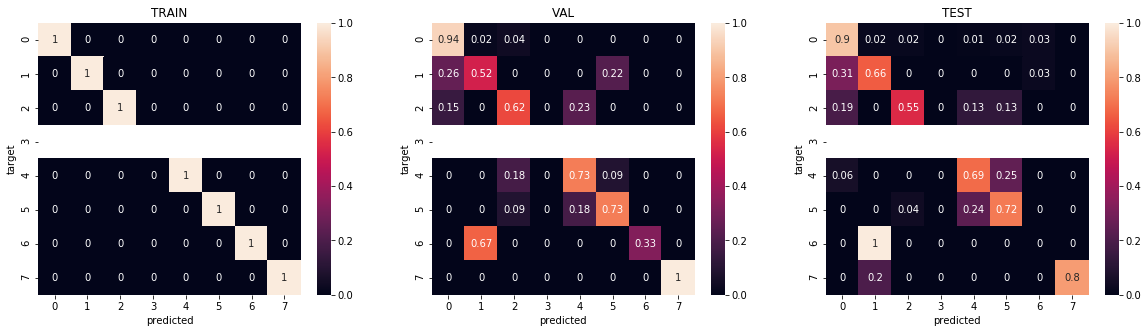

In [14]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# best model, batch weights
train_cm, val_cm, test_cm = normalize_confusion_matrix(train_cm), normalize_confusion_matrix(val_cm), normalize_confusion_matrix(test_cm)

plt.figure(figsize = (20,5))

plt.subplot(131)

df_cm = pd.DataFrame(train_cm, index = range(8), columns = range(8))

plt.title("TRAIN")
ax = sn.heatmap(df_cm, annot=True, vmin=0, vmax=1)
ax.set(xlabel='predicted', ylabel='target')

plt.subplot(132)

df_cm = pd.DataFrame(val_cm, index = range(8), columns = range(8))

plt.title("VAL")
ax = sn.heatmap(df_cm, annot=True, vmin=0, vmax=1)
ax.set(xlabel='predicted', ylabel='target')

plt.subplot(133)

df_cm = pd.DataFrame(test_cm, index = range(8), columns = range(8))

plt.title("TEST")
ax = sn.heatmap(df_cm, annot=True, vmin=0, vmax=1)
ax.set(xlabel='predicted', ylabel='target')

# plt.savefig("lightgbm-confusion-matrices.png", bboxes="tight")

In [16]:
make_directory("results/lgbm/")
gbm.save_model("results/lgbm/lightgbm-model.txt")